In [76]:
import os
import argparse
import json
import glob
import nibabel as nib
import numpy as np
import pandas as pd 
import matplotlib as plt
import matplotlib.pyplot as pltpy
from matplotlib.backends.backend_pdf import PdfPages
import seaborn
import math
#import plotnine as p9
try :
    import seaborn as sns
except : 
    ! pip install seaborn
    import seaborn as sns

from skimage.util import montage 
from skimage.transform import rotate
try : 
    import openxyl
except : 
    ! pip install openpyxl

%matplotlib inline
try :
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
except : 
    ! pip install brainstat
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from itertools import combinations
from brainspace.datasets import load_mask
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.mesh.mesh_operations import combine_surfaces
from brainspace.utils.parcellation import map_to_labels
from brainspace.vtk_interface import wrap_vtk, serial_connect
from vtk import vtkPolyDataNormals
from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from brainspace.mesh.mesh_io import read_surface
from IPython.display import display,Image
import statsmodels.api as sm
from brainstat.stats.terms import FixedEffect
from brainstat.stats.terms import MixedEffect
from brainstat.stats.SLM import SLM
import scipy.stats as stats
from scipy.stats import ttest_ind
import laBIBILaRORO as lbr
from importlib import reload


In [24]:
pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
mask_fslr32k = fetch_mask("fslr32k")
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

In [25]:
file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/HCP-MMP1_UniqueRegionList.csv'
df_exthcp = pd.read_csv(file_path)
#print(df_exthcp.head())  # Affiche les premières lignes du DataFrame

file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/Glasser_2016_Table-1.xlsx'
df_gla = pd.read_excel(file_path)
#df_gla

#attention entre el numero de regionID et le numero dans numpy ndarray il y aun decalge de 20 l'un recommence à 181 l'autre à 200
#mapping_dict = dict(zip(df_exthcp['regionID'], df_exthcp['Cortex_ID']))
mapping_dict = dict(zip(df_exthcp.index.values+1, df_exthcp['Cortex_ID']))

mapping_dict[0] = 0
def map_values(value):
    return mapping_dict.get(value, 400)  # Remplacer 0 par une autre valeur par défaut si nécessaire

for key in mapping_dict.keys():
    # Vérifier si la clé est supérieure à 180
    if key > 180:
        # Ajouter 22 à la valeur correspondante
        mapping_dict[key] += 22

# Utiliser np.vectorize pour appliquer la fonction de correspondance
vectorized_map = np.vectorize(map_values)
glasser_fslr32k_exthcp = vectorized_map(glasser_fslr32k)

#verif 
#set(mapping_dict.values())

## Affiche des infos principales

In [26]:
print(f"number of points in fslr32k = {glasser_fslr32k.shape[0]}, left and right = {inflated_left_fslr32k.GetPoints().shape[0]}")
print(f"number of points in fsaverage = {glasser.shape[0]}, left and right = {inflated_right.GetPoints().shape[0]}")
print(f"number of ROI values in glasser = {len(np.unique(glasser))}")
print(f"number of ROI values in HCP extended = {len(np.unique(glasser_fslr32k_exthcp))}")

number of points in fslr32k = 64984, left and right = 32492
number of points in fsaverage = 20484, left and right = 10242
number of ROI values in glasser = 361
number of ROI values in HCP extended = 45


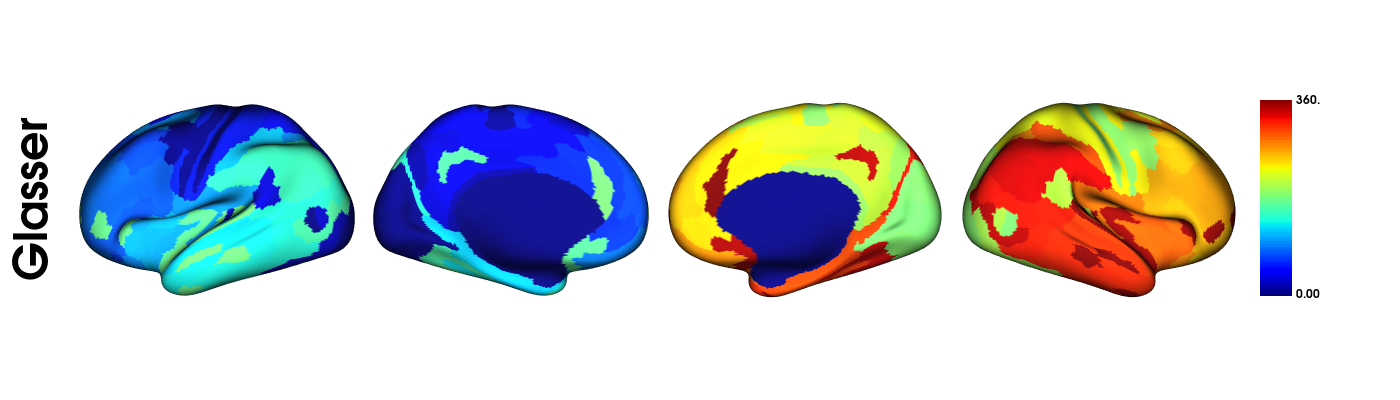

In [27]:
#np.where(np.isin(glasser_fslr32k, [1,4,5,6]),glasser_fslr32k, 0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

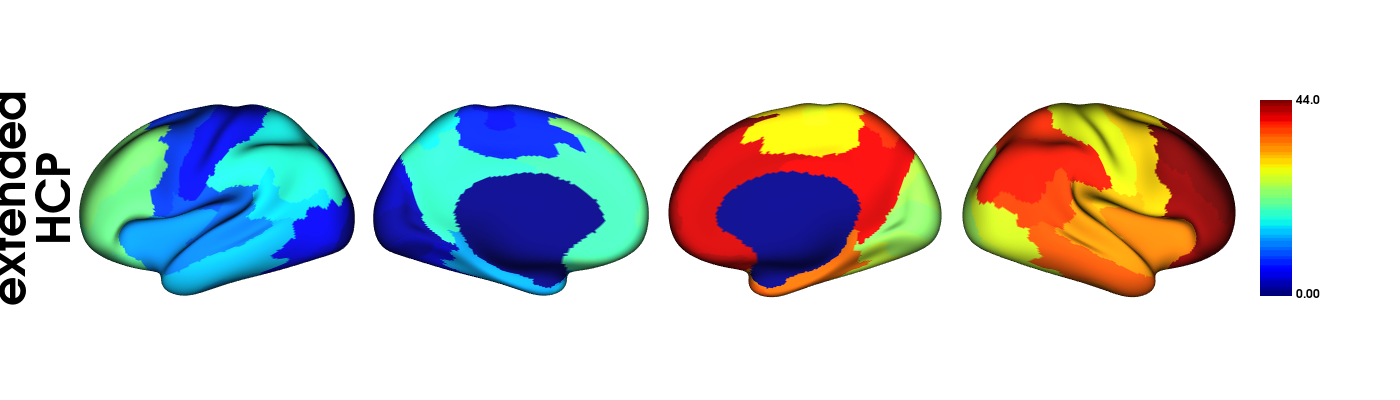

In [28]:
#np.where(np.isin(glasser_fslr32k, [1,2,3,4]),glasser_fslr32k, 0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k_exthcp, color_bar=True,
        label_text=["extended\nHCP"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

# Chargement des données propre à l'étude

In [55]:
STUDY_PATH=os.path.join("/NAS","fatmike","Protocoles_3T","Neurosclerodermie")
DERIVATIVE_PATH=os.path.join(STUDY_PATH,"data","bids","derivatives")
#SCRIPT_PATH=os.path.join(STUDY_PATH,'scripts')
#LOG_PATH=os.path.join(SCRIPT_PATH,'log')
DATA_FILE=os.path.join(STUDY_PATH,'neurosclerodermie_participants.xlsx')

In [75]:
#CLIData['Groupe_NAME'].unique()
palette = {
    'NoCogNoPsy': '#1f77b4',  # Bleu
    'CogNoPsy': '#ff7f0e',  # Orange
    'CogPsy': '#2ca02c',   # Vert
    'NoCogPsy': '#d62728',     # Rouge
    'CTRL' : '#9467bd' # Violet
}

In [ ]:
var4Cov=['AGE','IMC']

In [59]:
CLIData = pd.read_excel(DATA_FILE,index_col=0,engine='openpyxl')
CLIData.head()

Groupe  AGE   IMC
SUBJID                   
P0101        0   63  32.0
P0102        1   57  26.0
P0104        3   51  33.0
P0105        2   59  30.0
P0107        0   63  18.0

In [60]:
# Calculer la moyenne de la colonne IMC
mean_imc = CLIData['IMC'].mean()

# Imputer les valeurs manquantes avec la moyenne
CLIData['IMC'].fillna(mean_imc, inplace=True)

# Afficher les premières lignes pour vérifier
print(CLIData.head())

        Groupe  AGE   IMC
SUBJID                   
P0101        0   63  32.0
P0102        1   57  26.0
P0104        3   51  33.0
P0105        2   59  30.0
P0107        0   63  18.0


/tmp/ipykernel_3474936/3260783410.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CLIData['IMC'].fillna(mean_imc, inplace=True)


In [61]:
# Créer la colonne GROUPE_NAME en fonction des valeurs de GROUPE
def map_group_name(group):
    if group == 0:
        return 'NoCogNoPsy'
    elif group == 1:
        return 'CogNoPsy'
    elif group == 2:
        return 'NoCogPsy'
    elif group == 3:
        return 'CogPsy'
    elif group == 4:
        return 'CTRL'
    else:
        return 'Unknown'

CLIData['Groupe_NAME'] = CLIData['Groupe'].apply(map_group_name)

# Afficher le DataFrame pour vérifier les résultats
print(CLIData.head())


        Groupe  AGE   IMC Groupe_NAME
SUBJID                               
P0101        0   63  32.0  NoCogNoPsy
P0102        1   57  26.0    CogNoPsy
P0104        3   51  33.0      CogPsy
P0105        2   59  30.0    NoCogPsy
P0107        0   63  18.0  NoCogNoPsy


# Cortical thickness

In [62]:
valCT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(5, 26, 10)}
for smoothing_fwhm in range(5, 26, 10):
    print(f"Smoothing FWHM: {smoothing_fwhm} mm")
    for elt in CLIData.index:
        sub = f"sub-{str(elt)}"
        path_file_lh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-L_surf-fsaverage5_label-thickness_sm{smoothing_fwhm}.func.gii")
        path_file_rh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-R_surf-fsaverage5_label-thickness_sm{smoothing_fwhm}.func.gii")
        
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCT[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            print(sub)


Smoothing FWHM: 5 mm
Smoothing FWHM: 15 mm
Smoothing FWHM: 25 mm


In [67]:
CLIData.loc[CLIData['Groupe'] == 2]

Groupe  AGE   IMC Groupe_NAME
SUBJID                               
P0105        2   59  30.0    NoCogPsy
P0111        2   56  43.0    NoCogPsy
P0116        2   35  37.0    NoCogPsy
P0125        2   54  28.0    NoCogPsy
P0128        2   46  23.0    NoCogPsy
P0130        2   50  19.0    NoCogPsy
P0132        2   56  35.0    NoCogPsy
P0166        2   52  23.0    NoCogPsy
P0173        2   52  21.0    NoCogPsy
P0180        2   61  29.0    NoCogPsy
P0181        2   39  27.0    NoCogPsy
P0405        2   36  23.0    NoCogPsy
P0417        2   65  24.0    NoCogPsy
P0418        2   64  27.0    NoCogPsy

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogNoPsy_sm5.jpg


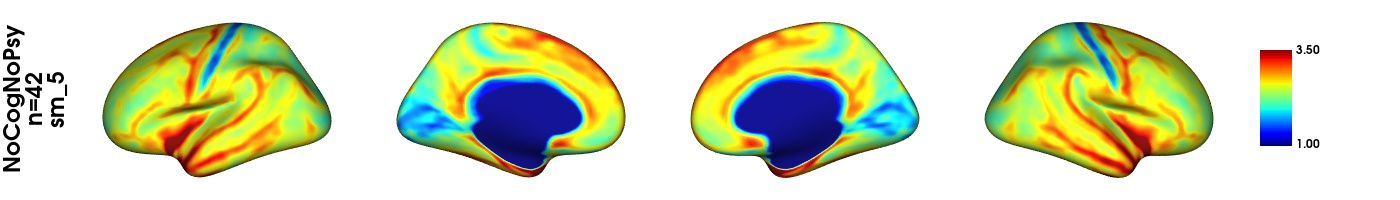

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogNoPsy_sm5.jpg


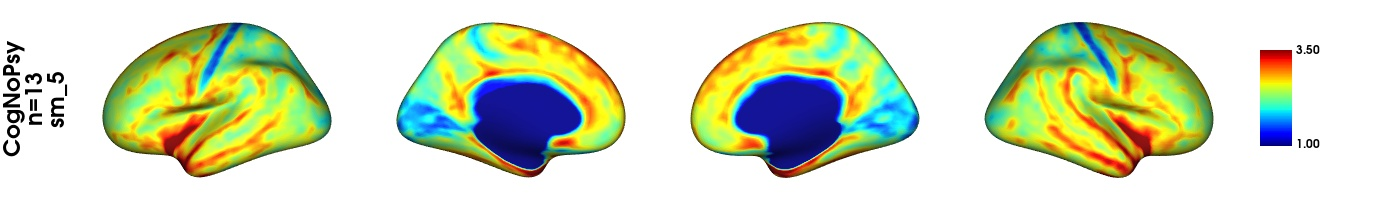

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogPsy_sm5.jpg


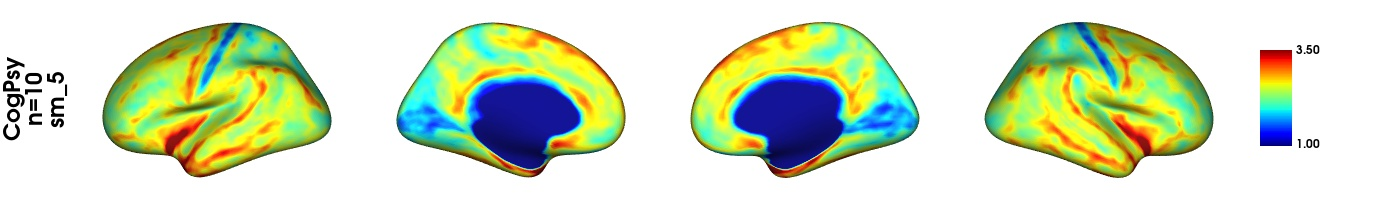

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogPsy_sm5.jpg


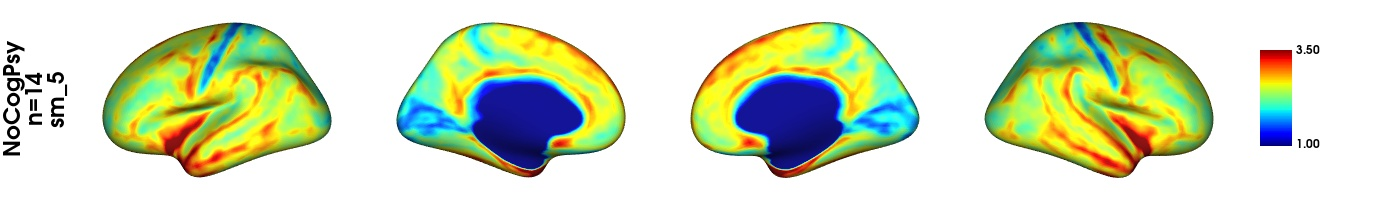

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CTRL_sm5.jpg


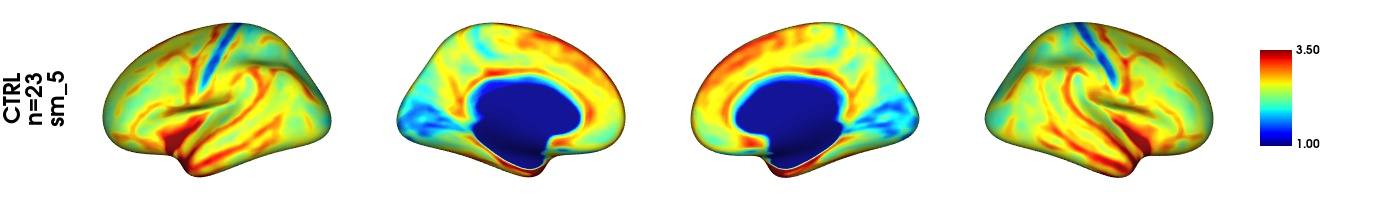

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogNoPsy_sm15.jpg


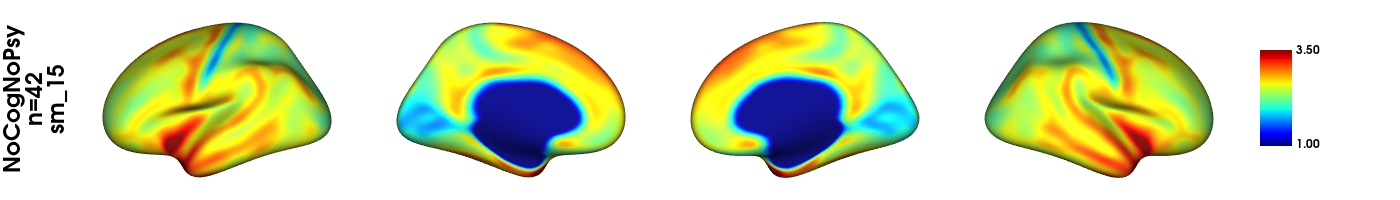

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogNoPsy_sm15.jpg


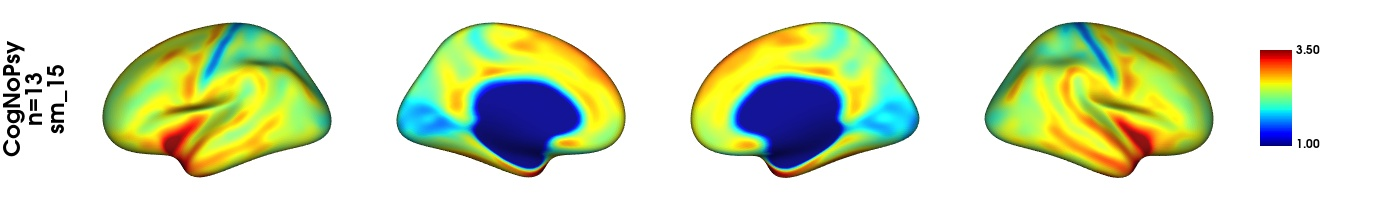

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogPsy_sm15.jpg


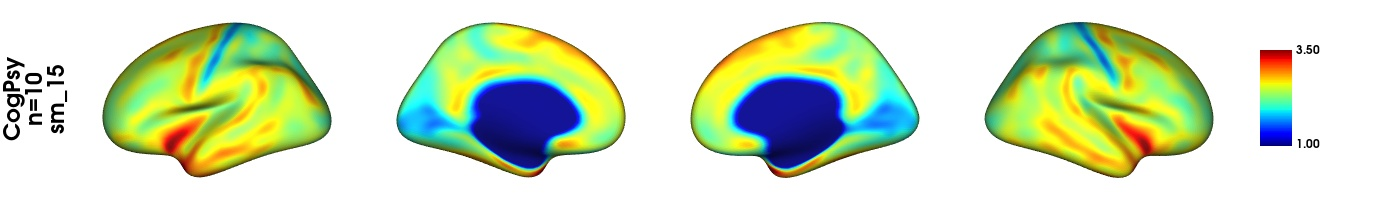

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogPsy_sm15.jpg


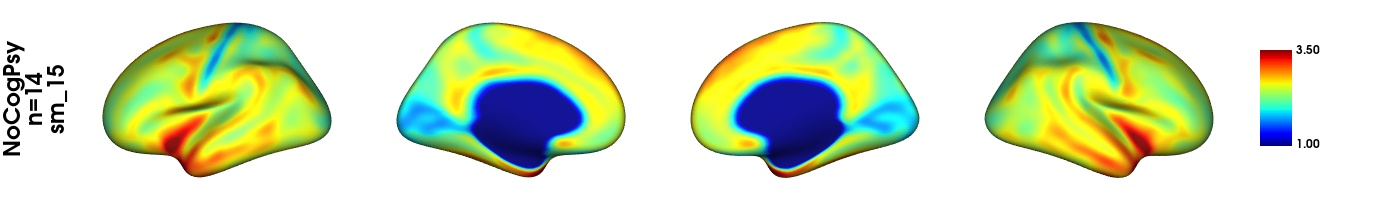

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CTRL_sm15.jpg


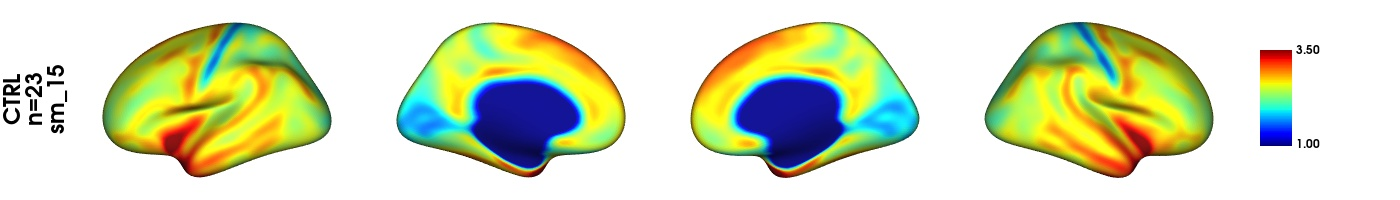

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogNoPsy_sm25.jpg


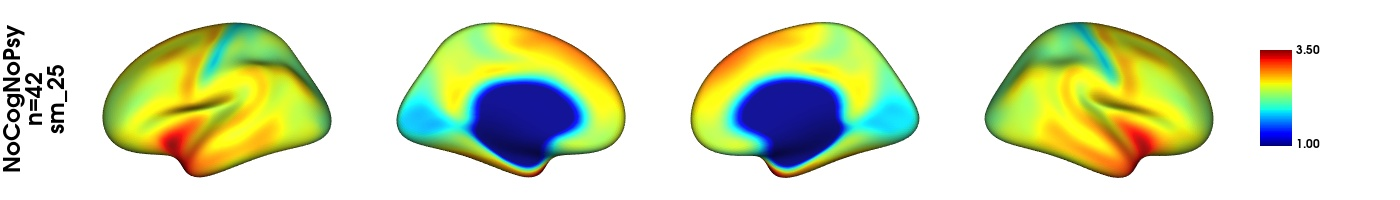

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogNoPsy_sm25.jpg


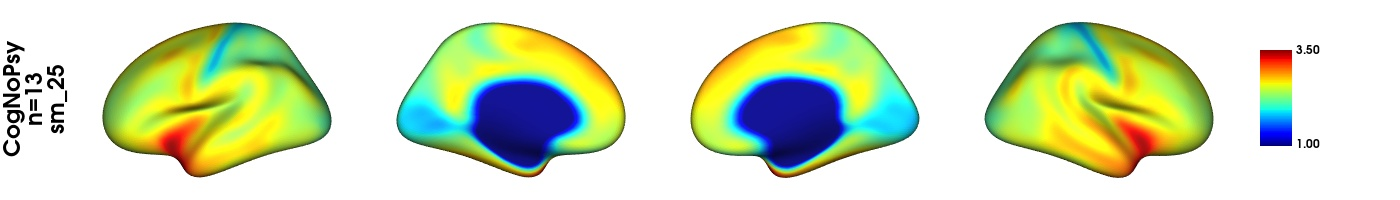

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogPsy_sm25.jpg


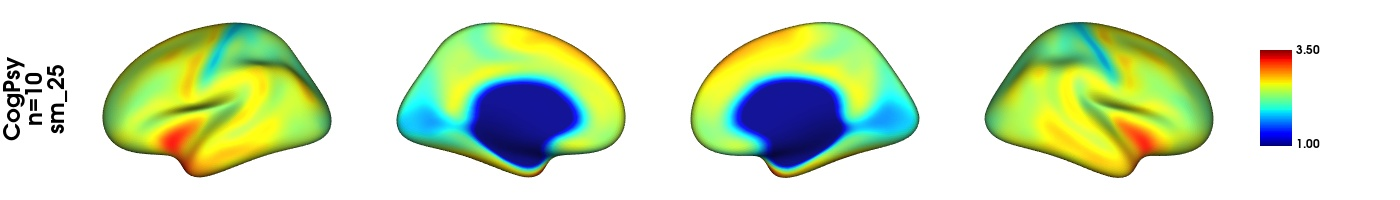

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogPsy_sm25.jpg


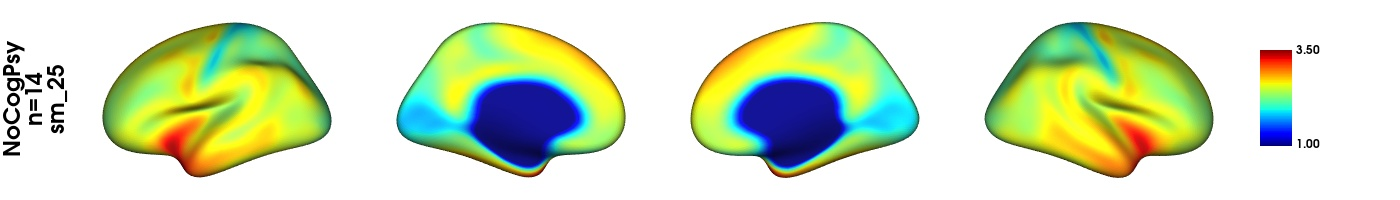

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CTRL_sm25.jpg


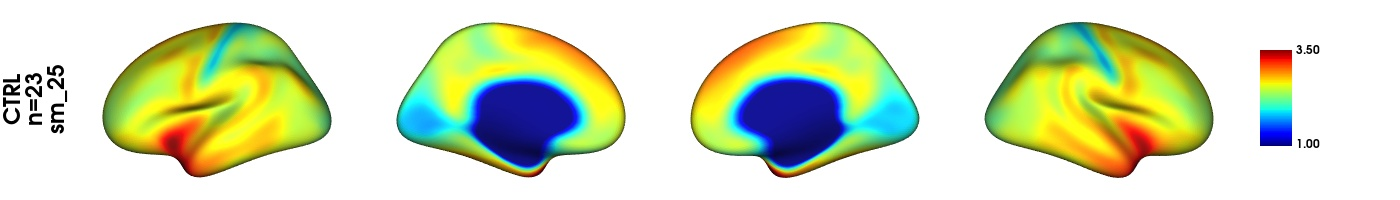

In [66]:
for smoothing_fwhm in range(5, 26, 10): #chain([11], range(15, 31, 5)):
        for gp in CLIData['Groupe_NAME'].dropna().unique():
                figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_{gp}_sm{smoothing_fwhm}.jpg")
                df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=CLIData.index)       
                df_tmp_gp=df_etude1_CT.loc[CLIData['Groupe_NAME'] == gp]
                plot_hemispheres(inflated_left, inflated_right,np.mean(df_tmp_gp,axis=0).values, color_bar=True, color_range=(1, 3.5),
                        label_text=[f"{gp}\nn={len(df_tmp_gp)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
                        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
                print(f"figure_title : {figure_title}")                        
                display(Image(filename=figure_title))

# Curvature

In [68]:
valCurv = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(5, 26, 10)}
for smoothing_fwhm in range(5, 26, 10):
    print(f"Smoothing FWHM: {smoothing_fwhm} mm")
    for elt in CLIData.index:
        sub = f"sub-{str(elt)}"
        path_file_lh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-L_surf-fsaverage5_label-curv_sm{smoothing_fwhm}.func.gii")
        path_file_rh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-R_surf-fsaverage5_label-curv_sm{smoothing_fwhm}.func.gii")
        
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCurv[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            print(sub)


Smoothing FWHM: 5 mm
Smoothing FWHM: 15 mm
Smoothing FWHM: 25 mm


figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogNoPsy_sm5.jpg


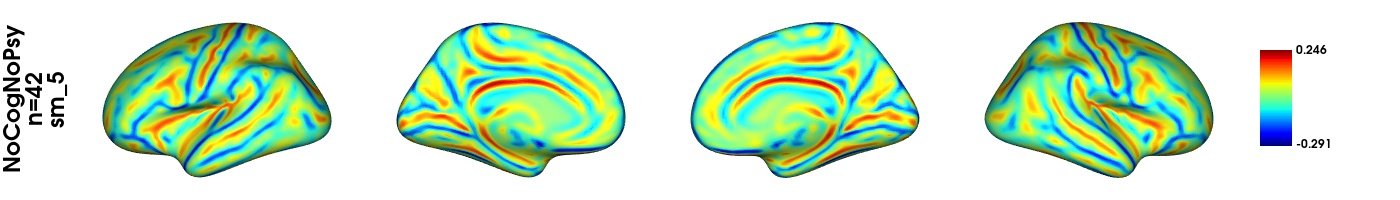

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogNoPsy_sm5.jpg


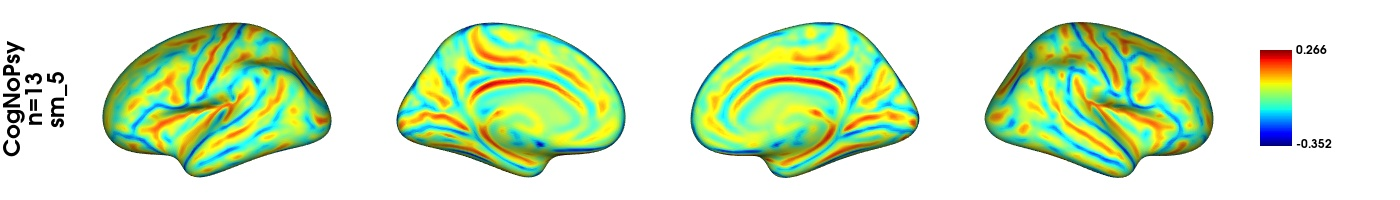

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogPsy_sm5.jpg


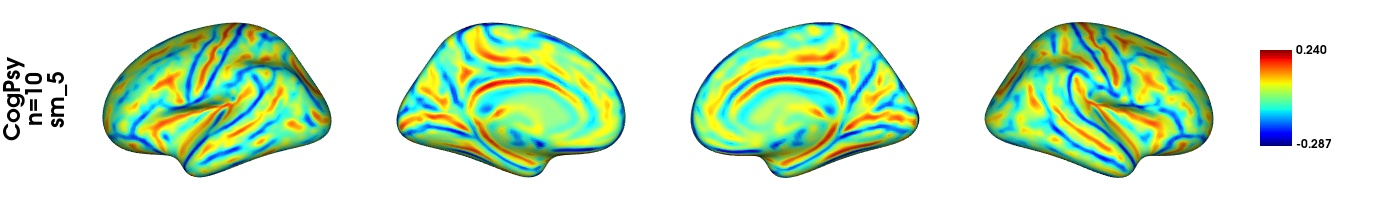

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogPsy_sm5.jpg


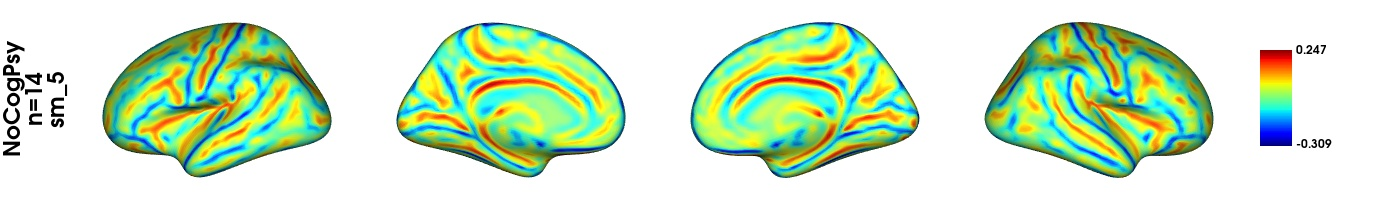

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CTRL_sm5.jpg


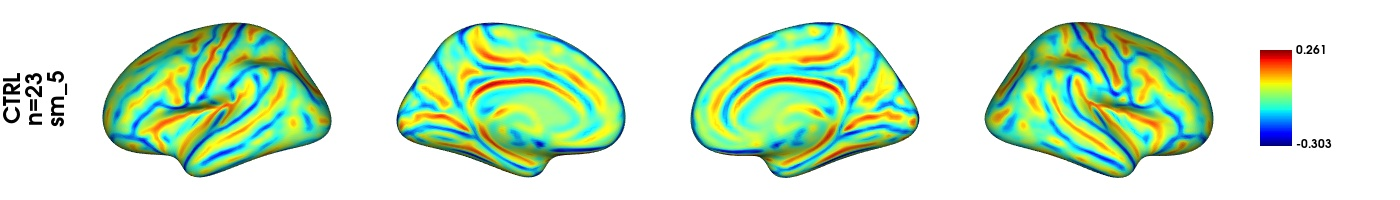

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogNoPsy_sm15.jpg


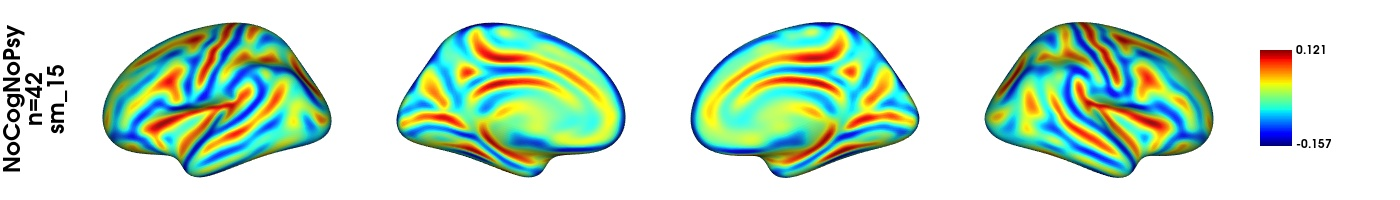

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogNoPsy_sm15.jpg


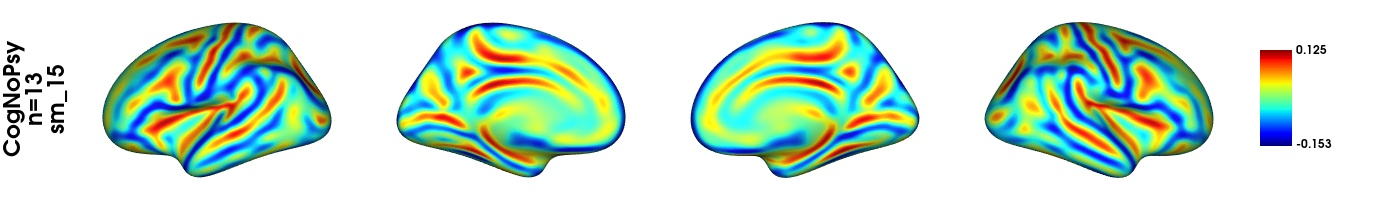

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogPsy_sm15.jpg


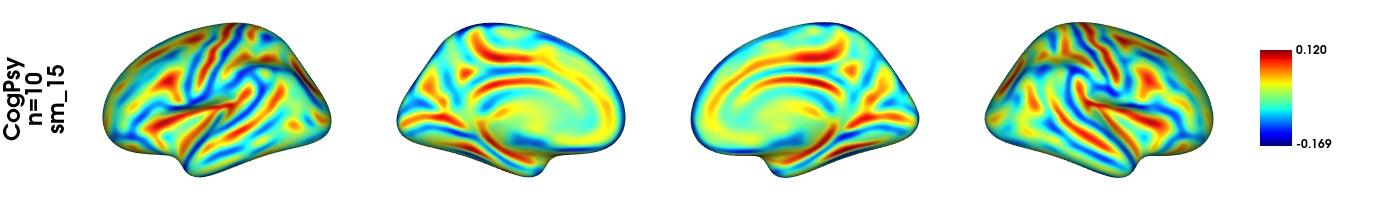

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogPsy_sm15.jpg


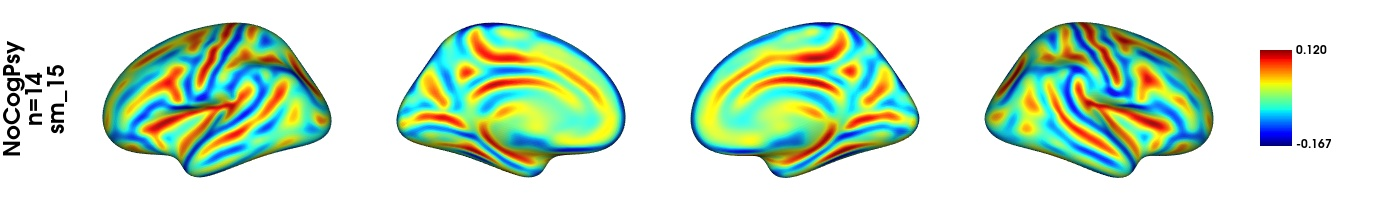

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CTRL_sm15.jpg


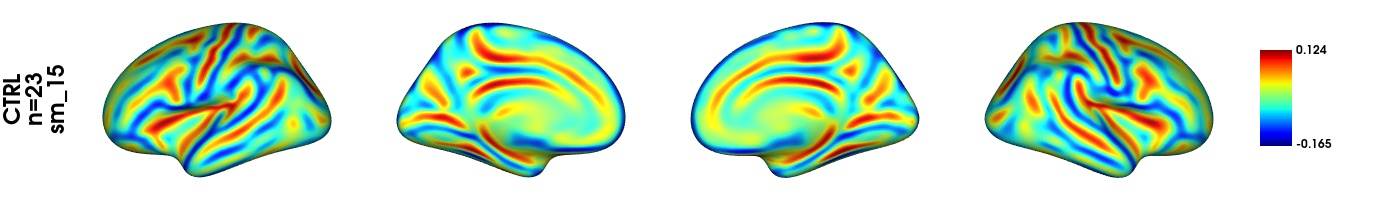

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogNoPsy_sm25.jpg


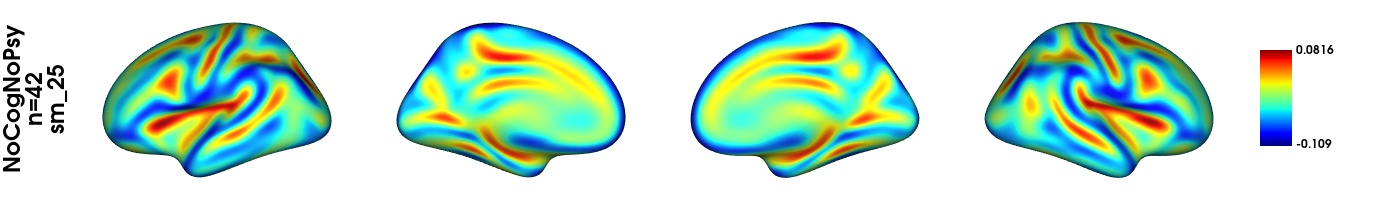

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogNoPsy_sm25.jpg


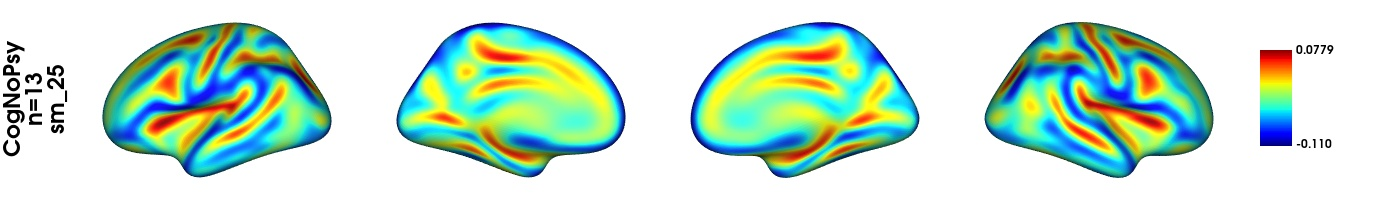

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogPsy_sm25.jpg


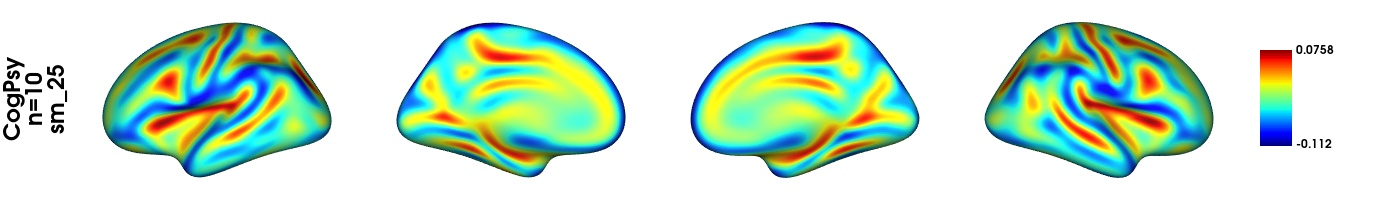

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogPsy_sm25.jpg


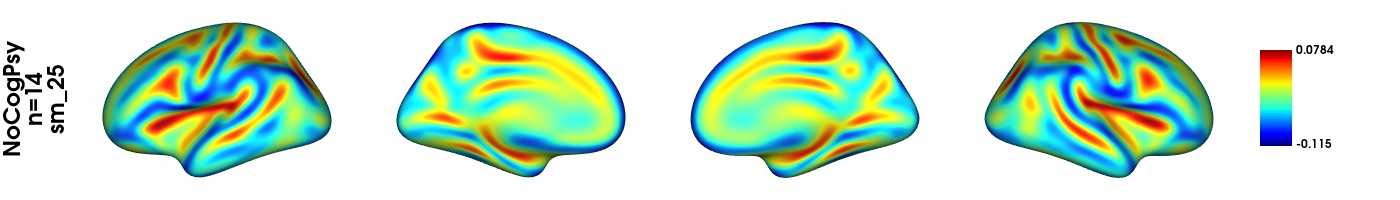

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CTRL_sm25.jpg


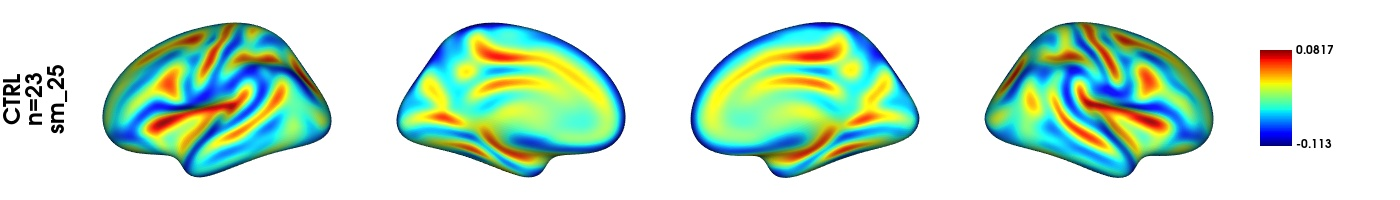

In [70]:
for smoothing_fwhm in range(5, 26, 10): #chain([11], range(15, 31, 5)):
        for gp in CLIData['Groupe_NAME'].dropna().unique():
                figure_title=os.path.join(STUDY_PATH,"screenshots",f"CurvSurface_{gp}_sm{smoothing_fwhm}.jpg")
                df_etude1_CT = pd.DataFrame(np.array(valCurv[f"sm_{smoothing_fwhm}"]), index=CLIData.index)       
                df_tmp_gp=df_etude1_CT.loc[CLIData['Groupe_NAME'] == gp]
                plot_hemispheres(inflated_left, inflated_right,np.mean(df_tmp_gp,axis=0).values, color_bar=True,
                        label_text=[f"{gp}\nn={len(df_tmp_gp)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
                        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
                print(f"figure_title : {figure_title}")                        
                display(Image(filename=figure_title))

In [ ]:
reload(lbr)
pd.option_context('mode.use_inf_as_na', True)
for smoothing_fwhm in range(5, 26, 100):
    print(f"\033[1;31m******************************\n smooting à {smoothing_fwhm}\n***************************** \033[0m")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(CLIData['Groupe_NAME'].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=CLIData.index)
        ssdf_CT = df_etude1_CT.loc[CLIData['Groupe_NAME'].isin([pair[0],pair[1]])]

            #Régression de l'age et du niveau d'education
            #lbr.regress_covar_func(df_etude1_CT.columns,var4Cov,ssdf_CT,merged_data.loc[merged_data[groupUsed].isin([pair[0],pair[1]])][var4Cov],True)

        ssdf_covar = CLIData.loc[ssdf_CT.index]

        # Construire le chemin du répertoire
        directory_path = os.path.join(STUDY_PATH, "screenshots", f"sm_{smoothing_fwhm}")

        # Créer le répertoire s'il n'existe pas
        os.makedirs(directory_path, exist_ok=True)
        lbr.grp_comp_surface_func('Groupe_NAME',var4Cov,ssdf_covar,ssdf_CT,directory_path,MyPalette=palette)

In [71]:
for cpt in range(15, 31, 500):
    print(cpt)

15


In [5]:
# Assuming read_surface is a function from brainspace.mesh.mesh_io
read_surface = mesh_io.read_surface

surf_lh = read_surface('/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/surf/lh.inflated', itype='fs')
surf_rh = read_surface('/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/surf/rh.inflated', itype='fs')


fileL = "/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/label/lh.aparc_mics.annot"
fileR = "/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/label/rh.aparc_mics.annot"
figPath = '/tmp/16428_micapipe_QC_P0101/sub-P0101_ses-1_atlas-aparc_desc-surf.png'
label = np.concatenate((nb.freesurfer.read_annot(fileL)[0], nb.freesurfer.read_annot(fileR)[0]), axis=0)
